In [1]:
import torch
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("is_available:", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device 0:", torch.cuda.get_device_name(0))


torch version: 2.5.1
torch.version.cuda: 12.1
is_available: True
device_count: 1
device 0: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
def snake_columns(data):
    """
    Standarize and returns snake_case columns
    """
    data.columns = [column.lower().replace(' ', '_') for column in data.columns]


pd.set_option('display.max_columns', None) 
warnings.filterwarnings('ignore') 

In [3]:
data =pd.read_csv(r"C:\Users\lokes\Desktop\ironhack\week7\project\nlp-Fake-or-Real-News\dataset\training_data.csv",sep='\t', names=["label", "text"])

In [4]:
df =data.copy()

In [5]:
df.head(5)

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [6]:
df["label"].value_counts()

label
0    17572
1    16580
Name: count, dtype: int64

In [7]:
df.duplicated().sum()

1946

In [8]:

columns_to_check = ['label', 'text'] 

df_subset_duplicates = df[df.duplicated(subset=columns_to_check, keep=False)]

df_subset_duplicates_sorted = df_subset_duplicates.sort_values(by=columns_to_check)

print(df_subset_duplicates_sorted.head())

       label                                               text
9904       0  12-yr old boy‚s mother helps him transition to...
17512      0  12-yr old boy‚s mother helps him transition to...
9241       0  3 presidents before trump promised to move u.s...
17086      0  3 presidents before trump promised to move u.s...
9776       0  75-yr old trump supporter says she‚d rather go...


In [9]:
df_cleaned = df.drop_duplicates(keep='first')

In [10]:
df_cleaned.duplicated().sum()

0

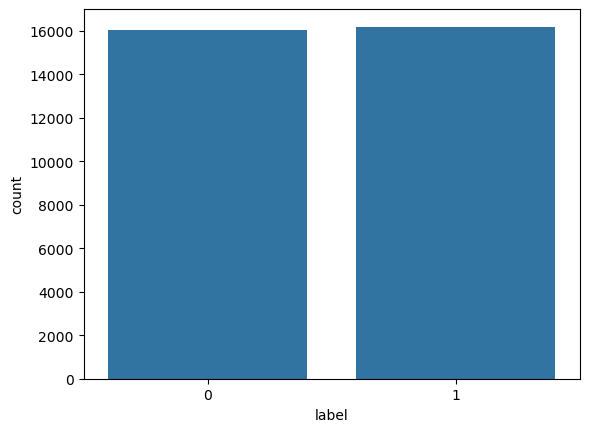

In [11]:
sns.countplot(x=df_cleaned["label"])
plt.show()

In [12]:
#!pip install "transformers[torch]"

In [13]:
#!pip install --upgrade transformers

In [14]:
print(df_cleaned['label'].value_counts())


label
1    16181
0    16025
Name: count, dtype: int64


In [15]:
import torch
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# =====================================================
# 1. Device selection
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# =====================================================
# 2. Load model and tokenizer
# =====================================================
from transformers.models.roberta import RobertaForSequenceClassification
from transformers import AutoTokenizer

model_name = "jy46604790/Fake-News-Bert-Detect"
print(f"\nLoading model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

# Move model to GPU and set to eval
model.to(device)
model.eval()

print("Model loaded successfully!")

# =====================================================
# 3. Batch prediction function with threshold
# =====================================================
def predict_batch(texts, batch_size=32, threshold=0.5):
    """
    Predict labels and confidences for a list of texts using batching.

    Model outputs logits for 2 classes: [FAKE, REAL] (0 = FAKE, 1 = REAL).
    Threshold is applied on REAL probability.
    """
    predictions = []
    confidences = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )

        # Move inputs to GPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            # probs: [batch_size, 2] with order [FAKE, REAL]

            real_probs = probs[:, 1]  # P(REAL)

            # Apply threshold on REAL: REAL (1) if p_real > threshold else FAKE (0)
            batch_predictions = (real_probs > threshold).long().cpu().numpy()

            # Confidence = max probability over classes
            batch_confidences = probs.max(dim=-1).values.cpu().numpy()

        predictions.extend(batch_predictions)
        confidences.extend(batch_confidences)

    return predictions, confidences

# =====================================================
# 4. Run scoring on your DataFrame
# =====================================================
# df_cleaned must already exist with columns: 'text' and 'label'
# label encoding here: 0 = FAKE, 1 = REAL

# You can tune this threshold:
THRESHOLD = 0.5  # try 0.4, 0.3, etc. to increase REAL recall

print(f"\nScoring {len(df_cleaned)} articles with threshold={THRESHOLD}...")

texts = df_cleaned["text"].tolist()
predictions, confidences = predict_batch(texts, batch_size=32, threshold=THRESHOLD)

# Add predictions to DataFrame
df_cleaned["predicted_label"] = predictions  # 0 = FAKE, 1 = REAL
df_cleaned["confidence"] = confidences

label_map = {0: "FAKE", 1: "REAL"}
df_cleaned["prediction"] = df_cleaned["predicted_label"].map(label_map)

# =====================================================
# 5. Basic counts
# =====================================================
print("\n--- Scoring Complete ---")
print(f"Total articles: {len(df_cleaned)}")

num_fake = predictions.count(0)   # predicted FAKE
num_real = predictions.count(1)   # predicted REAL

print(f"Predicted FAKE: {num_fake}")
print(f"Predicted REAL: {num_real}")
print(f"Average confidence: {sum(confidences) / len(confidences):.2%}")

# =====================================================
# 6. Metrics
# =====================================================
print("\n" + "=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)

y_true = df_cleaned["label"]          # 0 = FAKE, 1 = REAL
y_pred = df_cleaned["predicted_label"]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="binary")  # positive class = 1 (REAL)
recall = recall_score(y_true, y_pred, average="binary")
f1 = f1_score(y_true, y_pred, average="binary")

print(f"\nAccuracy:  {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision * 100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall * 100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1 * 100:.2f}%)")

# =====================================================
# 7. Confusion matrix
# =====================================================
print("\n" + "-" * 60)
print("CONFUSION MATRIX")
print("-" * 60)

cm = confusion_matrix(y_true, y_pred)
print("\n                Predicted")
print("              FAKE  REAL")
print(f"Actual FAKE  [{cm[0][0]:5d} {cm[0][1]:5d}]")
print(f"      REAL   [{cm[1][0]:5d} {cm[1][1]:5d}]")

# =====================================================
# 8. Detailed classification report
# =====================================================
print("\n" + "-" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("-" * 60)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["FAKE", "REAL"],
        digits=4
    )
)

# =====================================================
# 9. Sample predictions
# =====================================================
print("\n" + "-" * 60)
print("SAMPLE PREDICTIONS (5 examples)")
print("-" * 60)

sample_df = df_cleaned.sample(min(5, len(df_cleaned)), random_state=42)

sample_df = df_cleaned.sample(min(5, len(df_cleaned)), random_state=42)

for i, (idx, row) in enumerate(sample_df.iterrows(), 1):
    print(f"\n[{i}] Text: {row['text'][:100]}...")
    true_label = "FAKE" if row["label"] == 0 else "REAL"
    match = "✓" if row["prediction"] == true_label else "✗"
    print(f"    True Label: {true_label}")
    print(f"    Predicted:  {row['prediction']} (Confidence: {row['confidence']:.2%}) {match}")

print("\n" + "=" * 60)

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU

Loading model: jy46604790/Fake-News-Bert-Detect
Model loaded successfully!

Scoring 32206 articles with threshold=0.5...


Processing batches: 100%|██████████| 1007/1007 [00:58<00:00, 17.34it/s]



--- Scoring Complete ---
Total articles: 32206
Predicted FAKE: 27510
Predicted REAL: 4696
Average confidence: 98.25%

MODEL PERFORMANCE METRICS

Accuracy:  0.6386 (63.86%)
Precision: 0.9836 (98.36%)
Recall:    0.2855 (28.55%)
F1-Score:  0.4425 (44.25%)

------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------

                Predicted
              FAKE  REAL
Actual FAKE  [15948    77]
      REAL   [11562  4619]

------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE     0.5797    0.9952    0.7327     16025
        REAL     0.9836    0.2855    0.4425     16181

    accuracy                         0.6386     32206
   macro avg     0.7817    0.6403    0.5876     32206
weighted avg     0.7826    0.6386    0.5869     32206


------------------

In [16]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import numpy as np

# ============================
# 1. Device
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================
# 2. Data prep
# ============================
def prepare_data(df: pd.DataFrame):
    # map string labels if needed
    if df["label"].dtype == "object":
        mapping = {
            "fake": 0, "FAKE": 0,
            "real": 1, "REAL": 1,
            "true": 1, "TRUE": 1,
        }
        df["label"] = df["label"].map(mapping)

    df["label"] = df["label"].astype(int)

    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df["label"],
    )

    train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
    test_dataset = Dataset.from_pandas(test_df[["text", "label"]])
    return train_dataset, test_dataset

# df_cleaned must already exist with 'text' and 'label'
train_dataset, test_dataset = prepare_data(df_cleaned)

# ============================
# 3. Model & tokenizer
# ============================
model_name = "jy46604790/Fake-News-Bert-Detect"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

# ============================
# 4. Tokenization
# ============================
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)
test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

# ============================
# 5. TrainingArguments (minimal)
# ============================
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=torch.cuda.is_available(),
)

# ============================
# 6. Metrics
# ============================
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary"
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# ============================
# 7. Trainer, train, eval
# ============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

print("\nEvaluating model...")
results = trainer.evaluate()
print(f"\nTest Results: {results}")

# ============================
# 8. Inference helper
# ============================
def predict_fake_news(text: str):
    """
    LABEL_0: Fake, LABEL_1: Real
    """
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True,
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][predicted_class].item()

    label = "FAKE" if predicted_class == 0 else "REAL"
    return label, confidence

print("\n--- Example Predictions ---")
sample_texts = df_cleaned["text"].sample(3, random_state=0).tolist()
for i, text in enumerate(sample_texts, 1):
    label, conf = predict_fake_news(text)
    print(f"\nSample {i}:")
    print(f"Text preview: {text[:100]}...")
    print(f"Prediction: {label} (Confidence: {conf:.2%})")


Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Map: 100%|██████████| 6442/6442 [00:01<00:00, 5025.31 examples/s]


Starting training...


Step,Training Loss
10,0.968300
20,0.314800
30,0.265800
40,0.133800
50,0.372500
60,0.331700
70,0.151000
80,0.154500
90,0.189700
100,0.137300



Evaluating model...



Test Results: {'eval_loss': 0.08124252408742905, 'eval_accuracy': 0.9861844147780192, 'eval_precision': 0.9834152334152334, 'eval_recall': 0.9891875193080012, 'eval_f1': 0.9862929308486061, 'eval_runtime': 123.0377, 'eval_samples_per_second': 52.358, 'eval_steps_per_second': 3.275, 'epoch': 3.0}

--- Example Predictions ---

Sample 1:
Text preview: turkish police arrest 15 senior military officers in gulen probe: anadolu...
Prediction: REAL (Confidence: 99.99%)

Sample 2:
Text preview: wounded vet‚s mom forced to sell rare handwritten letter from obama promising to care for son‚to pay...
Prediction: FAKE (Confidence: 100.00%)

Sample 3:
Text preview: copts call for action over church closures in southern egypt...
Prediction: REAL (Confidence: 99.99%)


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nGenerating predictions on test set...")
pred_output = trainer.predict(test_dataset)
y_preds = np.argmax(pred_output.predictions, axis=1)
y_true = pred_output.label_ids



Generating predictions on test set...


In [18]:
# Raw confusion matrix
cm = confusion_matrix(y_true, y_preds)
print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

# Optional: with pandas for nicer display
cm_df = pd.DataFrame(
    cm,
    index=["true_fake(0)", "true_real(1)"],
    columns=["pred_fake(0)", "pred_real(1)"],
)
print("\nConfusion Matrix (DataFrame):")
print(cm_df)



Confusion Matrix (rows=true, cols=pred):
[[3151   54]
 [  35 3202]]

Confusion Matrix (DataFrame):
              pred_fake(0)  pred_real(1)
true_fake(0)          3151            54
true_real(1)            35          3202


In [19]:
target_names = ["FAKE (0)", "REAL (1)"]

print("\nClassification report:")
print(classification_report(y_true, y_preds, target_names=target_names, digits=4))



Classification report:
              precision    recall  f1-score   support

    FAKE (0)     0.9890    0.9832    0.9861      3205
    REAL (1)     0.9834    0.9892    0.9863      3237

    accuracy                         0.9862      6442
   macro avg     0.9862    0.9862    0.9862      6442
weighted avg     0.9862    0.9862    0.9862      6442



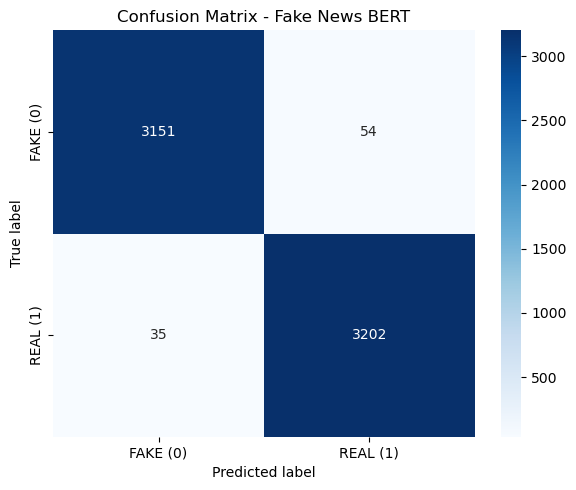

In [20]:
# Class labels: 0 = FAKE, 1 = REAL
labels = ["FAKE (0)", "REAL (1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Fake News BERT")
plt.tight_layout()
plt.show()


In [21]:
target_names = ["FAKE (0)", "REAL (1)"]

print("\nClassification report:")
print(classification_report(y_true, y_preds, target_names=target_names, digits=4))



Classification report:
              precision    recall  f1-score   support

    FAKE (0)     0.9890    0.9832    0.9861      3205
    REAL (1)     0.9834    0.9892    0.9863      3237

    accuracy                         0.9862      6442
   macro avg     0.9862    0.9862    0.9862      6442
weighted avg     0.9862    0.9862    0.9862      6442

